Drive connect


In [ ]:
!nvidia-smi

Thu Nov 27 06:19:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import os

# ==========================================
# 1. SETUP PATH & LOAD CSV
# ==========================================
# Ganti dengan lokasi folder dataset Anda di Google Drive
DATASET_DIR = '/content/drive/MyDrive/train_sampahv2'
CSV_FILE = os.path.join(DATASET_DIR, '_classes.csv')

# Baca CSV
df = pd.read_csv(CSV_FILE)

# Bersihkan nama kolom (hapus spasi di awal/akhir jika ada)
df.columns = df.columns.str.strip()

# Asumsi: Kolom pertama adalah nama file gambar (biasanya 'filename')
# Jika nama kolomnya bukan 'filename', ganti baris ini:
filename_col = df.columns[0]

print(f"Total Data: {len(df)} gambar")
print("Contoh Data:")
print(df.head())

# ==========================================
# 2. LABEL MAPPING (PENTING!)
# ==========================================
# Kita tentukan kolom mana saja yang masuk kategori "Kertas/Tisu"
# Sesuaikan string ini PERSIS dengan header di CSV Anda (Gambar 2)
PAPER_COLUMNS = ['Paper', 'Paper Contain', 'Paper Cup', 'Tissue']

def get_binary_label(row):
    # Cek apakah salah satu kolom kertas bernilai 1
    is_paper = 0
    for col in PAPER_COLUMNS:
        # Pake try-except biar kalau kolom ga ada, ga error
        try:
            if row[col] == 1:
                is_paper = 1
                break
        except KeyError:
            continue

    if is_paper == 1:
        return 'kertas_tisu'
    else:
        return 'anorganik_lain'

# Terapkan fungsi ke seluruh baris
df['final_label'] = df.apply(get_binary_label, axis=1)

print("\nDistribusi Kelas Baru:")
print(df['final_label'].value_counts())

# ==========================================
# 3. SPLIT DATA (TRAIN & VAL)
# ==========================================
# Karena foldernya nyampur, kita pisah 80:20 pakai code
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['final_label'], random_state=42)

# ==========================================
# 4. DATA GENERATOR (Flow from Dataframe)
# ==========================================
IMG_SIZE = (224, 224) # MobileNetV2 butuh 224, meski gambar asli 640
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3], # Simulasi cahaya gelap/terang
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

print("\n--- Menyiapkan Generator ---")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=DATASET_DIR,       # Folder tempat gambar numpuk
    x_col=filename_col,          # Kolom nama file
    y_col='final_label',         # Kolom label hasil olahan kita tadi
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=DATASET_DIR,
    x_col=filename_col,
    y_col='final_label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# ==========================================
# 5. MODEL BUILD (Transfer Learning)
# ==========================================
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE+(3,))
base_model.trainable = False

inputs = Input(shape=IMG_SIZE+(3,))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# ==========================================
# 6. TRAINING PROCESS
# ==========================================
print("\n>>> Memulai Training...")
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Hitung Class Weight manual (biar adil)
from sklearn.utils import class_weight
label_map = train_generator.class_indices
print(f"Label Mapping: {label_map}")

# Convert labels ke angka untuk hitung bobot
train_labels_idx = [label_map[x] for x in train_df['final_label']]
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_idx),
    y=train_labels_idx
)
class_weights_dict = dict(enumerate(class_weights))

history = model.fit(
    train_generator,
    epochs=15, # Bisa ditambah jadi 25 jika perlu
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, lr_scheduler]
)

# ==========================================
# 7. SIMPAN MODEL
# ==========================================
model.save('model_sampah_csv_custom.h5')
print("Model berhasil disimpan!")

Total Data: 3600 gambar
Contoh Data:
                                            filename  Paper  Paper Container  \
0  plastic431_jpg.rf.6de45c31c246e8f432fc2c86dd12...      0                0   
1  images105-2-_jpg.rf.9b16c712cf82707bef6b8a65f5...      0                0   
2  images283-2-_jpg.rf.9c2e5e76ef3d16a7f532bc649d...      0                0   
3  crumpled-tissue-paper-13496707_jpg.rf.dd6b97a2...      0                0   
4  plastic91_jpg.rf.9603701ce56cf7c9d8327dfb14b5d...      0                0   

   Paper Cup  Plastic Bag  Plastic Bottle  Plastic Container  Plastic Cup  \
0          0            0               0                  1            0   
1          0            0               0                  0            0   
2          0            0               0                  0            1   
3          0            0               0                  0            0   
4          0            0               1                  0            0   

   Plastic Cutlery 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 2201s 24s/step - accuracy: 0.7209 - loss: 0.5612 - val_accuracy: 0.8958 - val_loss: 0.2445 - learning_rate: 0.0010
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 54s 594ms/step - accuracy: 0.8827 - loss: 0.2960 - val_accuracy: 0.8875 - val_loss: 0.2753 - learning_rate: 0.0010
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 53s 590ms/step - accuracy: 0.8875 - loss: 0.2724 - val_accuracy: 0.9153 - val_loss: 0.2063 - learning_rate: 0.0010
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 53s 591ms/step - accuracy: 0.9063 - loss: 0.2258 - val_accuracy: 0.9111 - val_loss: 0.2183 - learning_rate: 0.0010
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 614ms/step - accuracy: 0.9040 - loss: 0.2183 - val_accuracy: 0.9167 - val_loss: 0.1929 - learning_rate: 0.0010
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 54s 596ms/step - accuracy: 0.9226 - loss: 0.1914 - val_accuracy: 0.9222 - val_loss: 0.1893 - learning_rate: 0.0010
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 54s 595ms/step - accuracy: 0.9109 - loss: 0.

Model berhasil disimpan!


model


visualisasi


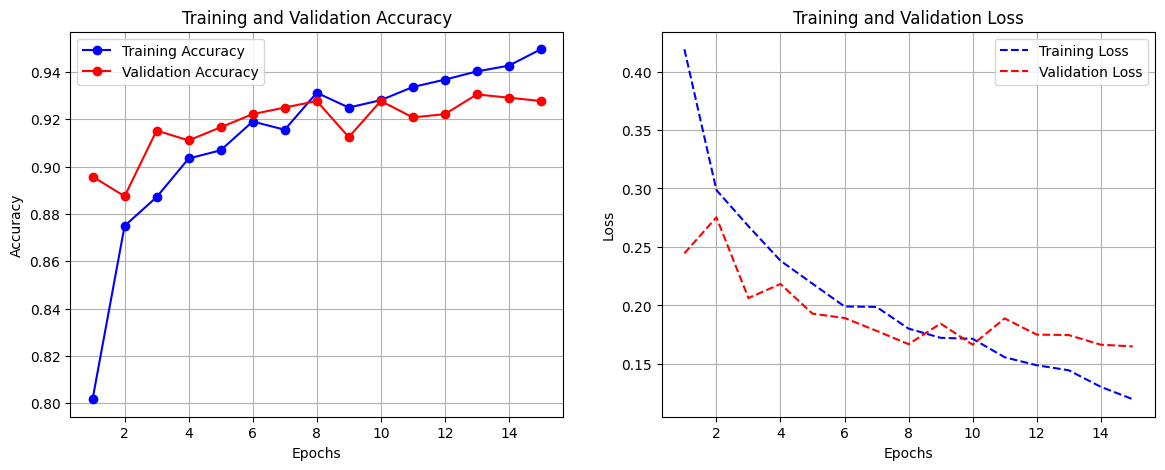

Sedang melakukan prediksi pada data validasi...
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step


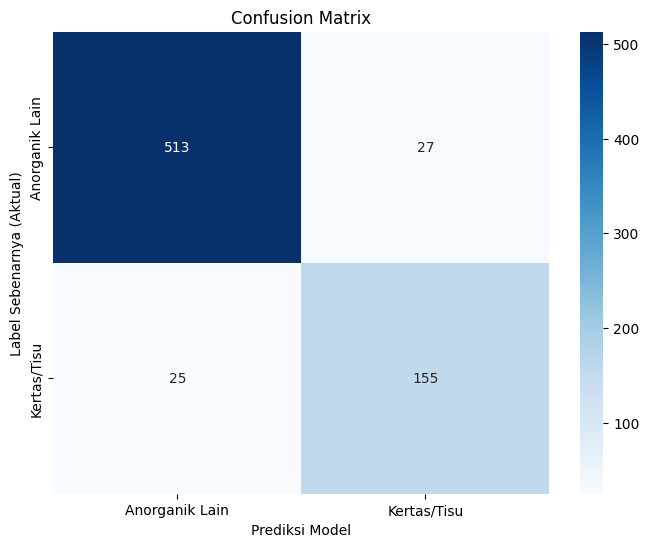


Laporan Klasifikasi Lengkap:
                precision    recall  f1-score   support

Anorganik Lain       0.95      0.95      0.95       540
   Kertas/Tisu       0.85      0.86      0.86       180

      accuracy                           0.93       720
     macro avg       0.90      0.91      0.90       720
  weighted avg       0.93      0.93      0.93       720

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


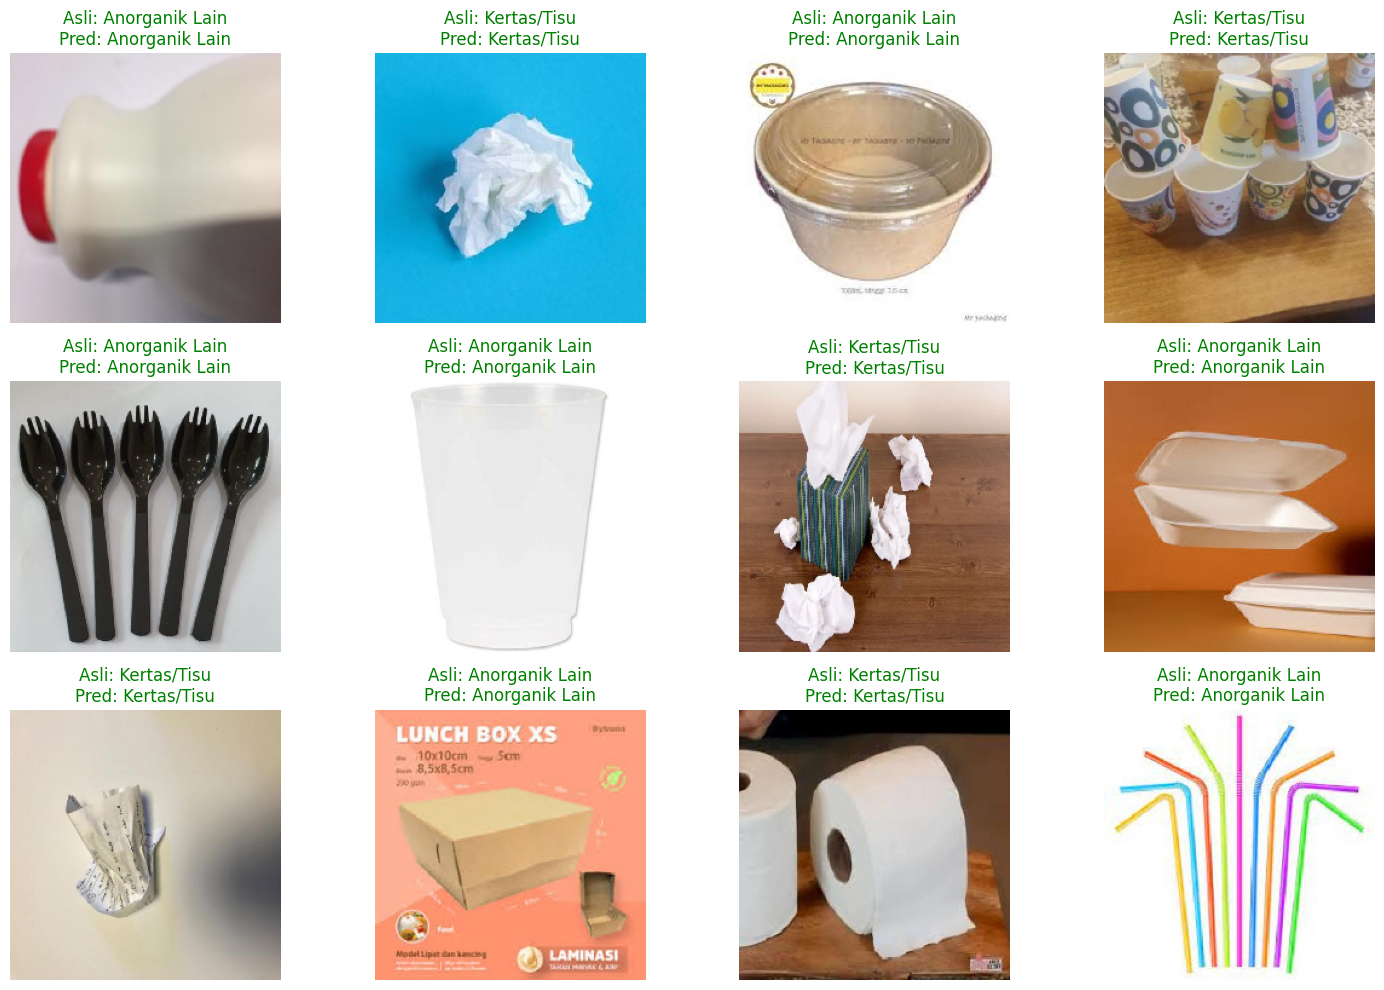

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b--', label='Training Loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

# Panggil fungsinya
plot_history(history)

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# 1. Reset generator agar urutan data validasi mulai dari awal
val_generator.reset()

# 2. Prediksi semua data validasi
print("Sedang melakukan prediksi pada data validasi...")
predictions = model.predict(val_generator, verbose=1)
predicted_classes = (predictions > 0.5).astype(int).ravel() # Convert 0.7 -> 1, 0.2 -> 0

# 3. Ambil label asli
true_classes = val_generator.classes

# 4. Buat Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# 5. Visualisasi Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Anorganik Lain', 'Kertas/Tisu'],
            yticklabels=['Anorganik Lain', 'Kertas/Tisu'])
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya (Aktual)')
plt.title('Confusion Matrix')
plt.show()

# 6. Cetak Laporan Detail (Precision, Recall, F1-Score)
print("\nLaporan Klasifikasi Lengkap:")
print(classification_report(true_classes, predicted_classes, target_names=['Anorganik Lain', 'Kertas/Tisu']))

# Ambil satu batch data dari validasi
val_generator.reset()
x_val, y_val = next(val_generator)

# Prediksi batch tersebut
preds = model.predict(x_val)
pred_labels = (preds > 0.5).astype(int)

# Mapping angka ke nama kelas
class_names = {0: 'Anorganik Lain', 1: 'Kertas/Tisu'}

plt.figure(figsize=(15, 10))
for i in range(min(12, len(x_val))): # Tampilkan maksimal 12 gambar
    plt.subplot(3, 4, i + 1)
    plt.imshow(x_val[i])

    # Tentukan warna teks (Hijau = Benar, Merah = Salah)
    actual = int(y_val[i])
    predicted = int(pred_labels[i][0])
    color = 'green' if actual == predicted else 'red'

    plt.title(f"Asli: {class_names[actual]}\nPred: {class_names[predicted]}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

fine tuning


akurasi ulang